In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/train.csv


In [2]:
import numpy as np
import pandas as pd
import re
import string
import gensim #word2vec에 사용

from nltk.corpus import stopwords #remove_stopwords 에 사용
from nltk.stem import WordNetLemmatizer #lemmatization 에 사용
from nltk.stem import PorterStemmer #stemming 에 사용
from nltk import word_tokenize #tokenization 에 사용 주로 쓰는게 이것과 nltk 의 WordPunctTokenizer


df_train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
df_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

print('train set shape = {}'.format(df_train.shape))
print('test set shape = {}'.format(df_test.shape))
print(df_train.head())

# url 제거
def remove_url(text):
    url = re.compile(r'https?://www.')
    text = url.sub(r'', text)
    return text

# html 제거
def remove_html(text):
    html = re.compile(r'<.*?>')
    text = html.sub(r'', text)
    return text

# punctuation 제거
def remove_punctuation(text):
    text = ''.join([char for char in text if char not in string.punctuation])
    return text

'''def remove_punctuation(text):
    table = str.maketrans(string.punctuation, str([' ' for _ in range(len(string.punctuation))]))
    text = text.translate(table)
    return text'''
'''
문자 바꾸기
>>> table = str.maketrans('aeiou', '12345') a는 1 e는 2 ... 에 대응하는 테이블이 만들어짐
>>> 'apple'.translate(table) 테이블에 맞게 문자변경 (기존 apple이 바뀌는게 아님! immutable 이니께)
'1ppl2'
string.punctuation 과 길이가 같은 값을 넣어줘야하는데.. 리스트로 넣어줘야하는 argument면 [' ' for _ in range(len(string.punctuation))] 식으로 넣으면 될지도 
위의 코드 억지로 str() 했는데도 안됨ㅜㅜ 일단 다른방식으로 쓰자
'''
'''
>>> string.punctuation
'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
'''
# stopwords 제거
stopwords = set(stopwords.words()) # 앗 이거 함수 안으로 넣으면 안되네?
#nltk의 stopwords는 wordcloud의 stopwords하고 다른가봐 후자는 그냥 단어 리스트를 줬는데 얘는 도구인듯. 이렇게 다시 한번 설정해줘야 한다.
def remove_stopwords(text):
    text = ' '.join([word for word in text.split() if word not in stopwords])
    return text

# lemmatization 작업
def lemmatization(text):
    n = WordNetLemmatizer()
    text = ' '.join([n.lemmatize(word) for word in text.split()])
    return text

# stemming 작업
p = PorterStemmer()
def stemming_text(text):
    text = ' '.join([p.stem(word) for word in text.split()]) #stem 뒤에는 리스트가 아니라 string이 들어가야 한다. 즉 리스트화와 stem의 순서를 바꿔줘야함
    return text


def cleaning_text(text):
    #위의 helper function 전부 합친거. 더 예쁘고 간단하게 쓰고싶은데..
    text = remove_url(text)
    text = remove_html(text)
    text = remove_punctuation(text)
    text = text.lower()
    text = remove_stopwords(text)
    text = lemmatization(text)
    text = stemming_text(text)
    return text

df_total = pd.concat([df_train, df_test])
df_total['text'] = df_total['text'].apply(lambda x: cleaning_text(x))
print(df_total['text'].head())
# text cleaning 완료

# tokenization
# 토큰화 거치면 어떤 데이터타입으로 내보내야 하지? word2vec 이나 glove가 뭘 input 으로 받는지 확인
def tokenization(text):
    '''
    라이브러리 안쓰고 그냥 이렇게도 하길래 나도 해봄 뭐야 제대로 안되는데?
    tokens = re.split('/W+', text)
    return tokens'''
    tokens = word_tokenize(text)
    return tokens

tokens = df_total['text'].apply(lambda x: tokenization(x))
print(tokens.head())

'''# word embedding
model = gensim.models.Word2Vec(size=150, window=5, workers=4, sg=0, min_count=5)
model.build_vocab(tokens)
model.train(sentences=tokens, total_examples=len(tokens), epochs=model.epochs)
word_vectors = model.wv
print(len(word_vectors.vocab))'''


'''word_vectors = model.wv
count = 0
for word in word_vectors.vocab:
    if count<10:
        print(word)
        count += 1
    else:
        break'''
'''vector = model.wv["earthquak"]  # model.mv가 단어 : 벡터로 이루어진 딕셔너리인듯
print(len(vector))
print(vector)'''

# 정수 인코딩
def gen_voca(tokenized_text):
    voca = {}
    for sample in tokenized_text:
        for token in sample:
            if token not in voca:
                voca[token] = 0
            else:
                voca[token] += 1
    return voca

def indexing(voca, min_freq, voca_size):
    voca_sorted = sorted(voca.items(), key = lambda x:x[1], reverse=True)
    word_index = {}
    i = 0
    for (word, frequency) in voca_sorted:
        if frequency > min_freq:
            i += 1
            word_index[word] = i

    word_frequency = [w for w,c in word_index.items() if c > voca_size]
    for w in word_frequency:
        del word_index[w]
    word_index['OOV'] = len(word_index) + 1

    return word_index

voca = gen_voca(tokens)
print(len(voca))
word_index = indexing(voca, 1, 10000) # 어차피 한번 나오는거 빼면 5000개도 안되네
print(word_index)
print(len(word_index))

def integer_encoding(word_index, tokenized_text):
    encoded = []
    for sentence in tokenized_text:
        temp = []
        for word in sentence:
            try:
                temp.append(word_index[word])
            except KeyError:
                temp.append(word_index['OOV'])
        encoded.append(temp)
    return encoded

encoded = integer_encoding(word_index, tokens)
print(encoded[:10])

def padding(encoded):
    max_len = 0
    for s in encoded:
        if len(s) > max_len:
            max_len = len(s)

    for s in encoded:
        while len(s) < max_len:
            s.append(0)

    padded_np = np.array(encoded)
    return padded_np

padded_np = padding(encoded)
print(padded_np[:10])


train set shape = (7613, 5)
test set shape = (3263, 4)
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
0             deed reason earthquak may allah forgiv u
1                    forest fire near rong sask canada
2    resid ask shelter place notifi offic evacu she...
3    13000 peopl receiv wildfir evacu order california
4    got sent photo rubi alaska smoke wildfir pour ...
Name: text, dtype: object
0     [deed, reason, earthquak, may, allah, forgiv, u]
1             [forest, fire, near, rong, sask, canada]

In [3]:
x_train = padded_np[:len(df_train)]
x_test = padded_np[len(df_train):]
y_train = np.array(df_train.target).reshape(-1, 1)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)

(7613, 24)
(3263, 24)
(7613, 1)


In [4]:
#원핫인코딩
from tensorflow.keras.utils import to_categorical

x_train_onehot = to_categorical(x_train)
x_test_onehot = to_categorical(x_test)

In [5]:
x_train_onehot.shape

(7613, 24, 4754)

In [6]:
x_train_onehot.nbytes

3474451392

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.layers import Embedding

In [8]:
model = Sequential()

model.add(Embedding(4754, 32))
model.add(SimpleRNN(8))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          152128    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 8)                 328       
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 152,465
Trainable params: 152,465
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
238/238 [==============================] - 2s 6ms/step - loss: 0.6717 - accuracy: 0.5780
Epoch 2/20
238/238 [==============================] - 2s 7ms/step - loss: 0.6551 - accuracy: 0.6164
Epoch 3/20
238/238 [==============================] - 2s 6ms/step - loss: 0.6340 - accuracy: 0.6516
Epoch 4/20
238/238 [==============================] - 2s 7ms/step - loss: 0.6050 - accuracy: 0.6904
Epoch 5/20
238/238 [==============================] - 2s 7ms/step - loss: 0.5778 - accuracy: 0.7157
Epoch 6/20
238/238 [==============================] - 2s 6ms/step - loss: 0.5522 - accuracy: 0.7378
Epoch 7/20
238/238 [==============================] - 2s 7ms/step - loss: 0.5302 - accuracy: 0.7553
Epoch 8/20
238/238 [==============================] - 2s 7ms/step - loss: 0.5133 - accuracy: 0.7663
Epoch 9/20
238/238 [==============================] - 2s 7ms/step - loss: 0.4927 - accuracy: 0.7825
Epoch 10/20
238/238 [==============================] - 2s 7ms/step - loss: 0.4829 - accuracy: 0.7890

In [10]:
import matplotlib.pyplot as plt

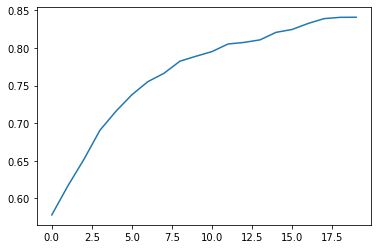

In [11]:
plt.plot(history.history['accuracy'])
plt.show()

In [12]:
a = model.predict(x_test)

In [13]:
y_hat = []
for i in a:
    if i > 0.5:
        y_hat.append(1)
    else:
        y_hat.append(0)
        
y_hat[:10]

[1, 1, 1, 1, 1, 1, 0, 0, 0, 0]

In [14]:
submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
submission.target = y_hat

In [15]:
submission.to_csv('submission.csv', index=False)